# Part 2: Multi Layer Perceptron 

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

from tqdm.notebook import trange

## Preparing the data 

In [16]:
words = open('names.txt', 'r').read().splitlines()

In [17]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [18]:
len(words)

32033

In [19]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [20]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## A two-layer neural network

In [21]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Our model uses an embedder mapping 27 characters to vectors in dimension 10
C = torch.randn((27, 10), generator=g)

# Then a linear layer with 200 neurons
# W1 is the multiplication matrix
W1 = torch.randn((30, 200), generator=g)
# b1 is the bias vector
b1 = torch.randn(200, generator=g)

# Then another linear layer which a distribution through a softmax
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True
# number of parameters in total
sum(p.nelement() for p in parameters) 

11897

In [22]:
lossi = []
stepi = []

for i in trange(200000):  
  # We construct a batch of 32 inputs
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # Forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log().item())

print(loss.item())

  0%|          | 0/200000 [00:00<?, ?it/s]

1.955472707748413


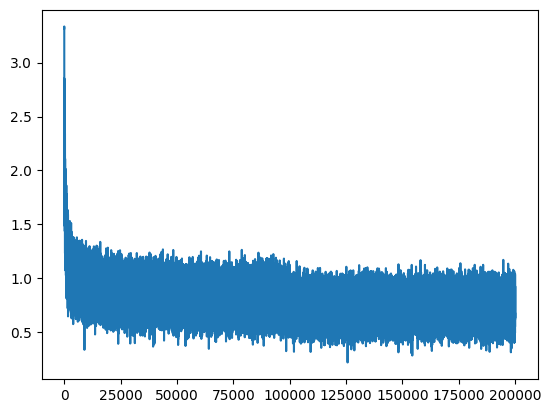

In [23]:
# Plot loss as number of iterations
plt.plot(stepi, lossi)

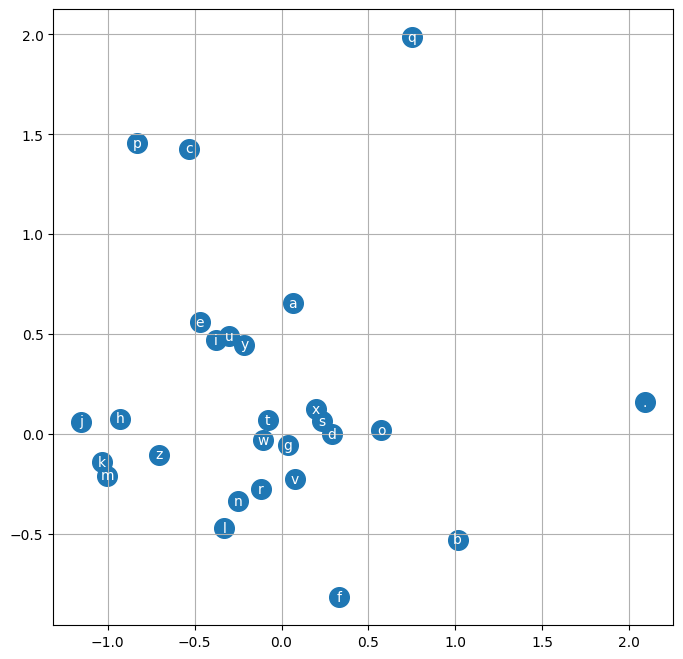

In [24]:
# Visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [26]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

junide.
jakarie.
pres.
amelina.
jirritolimar.
temmadahnaa.
yanilenaas.
dedaine.
immadse.
yicayla.
terinetumariffette.
maryas.
wah.
jaylicora.
yae.
anna.
jaleigh.
jamiia.
wyn.
leanaasnamirias.


## Bye Terinetumariffette!